In [1]:
import os
import cv2
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, LocallyLinearEmbedding as LLE, MDS
import warnings
warnings.filterwarnings('ignore')

# 1. Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?

In [2]:
# Define the path to the folder containing images
data_path = '/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/360 Rocks'

# Load images, convert to grayscale, and flatten
images = []
for file_name in os.listdir(data_path):
    img = cv2.imread(os.path.join(data_path, file_name))  
    if img is not None:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
        images.append(gray_img.flatten())  

images = np.array(images)  # Convert to numpy array
print("Loaded images shape:", images.shape)

Loaded images shape: (360, 640000)


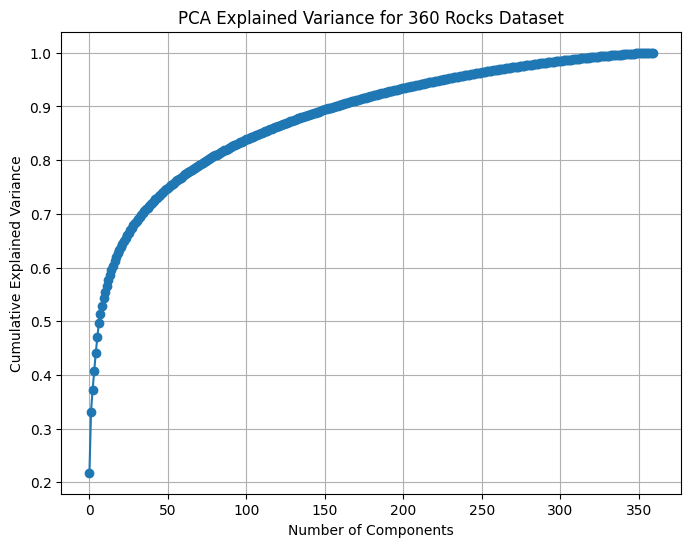

In [3]:
# Apply PCA
pca = PCA()
pca.fit(images)

# Calculate cumulative variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative variance explained by the principal components
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance for 360 Rocks Dataset')
plt.grid(True)
plt.show()

In [5]:
# Find the number of components required to retain 90% of the variance
n_components_90_var = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components needed to preserve 90% variance: {n_components_90_var}")

Number of components needed to preserve 90% variance: 158


# 2. Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA.

In [31]:
import random

# Randomly select 10 indices for the images to display
num_images = 10
selected_indices = random.sample(range(images.shape[0]), num_images)
selected_images = images[selected_indices]


In [32]:
# Initialize PCA with the number of components to preserve 90% variance
pca_90 = PCA(n_components=n_components_90_var)
images_pca = pca_90.fit_transform(images)  

# Transform and inverse transform the selected images to reconstruct them
reconstructed_images = pca_90.inverse_transform(images_pca[selected_indices])


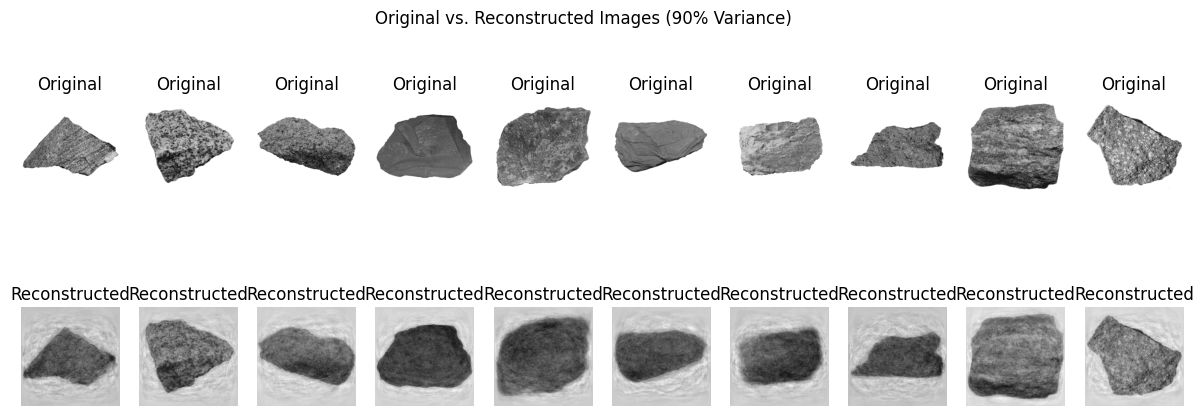

In [33]:
# Set up the plot
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
fig.suptitle("Original vs. Reconstructed Images (90% Variance)")

for i in range(num_images):
    # Original image
    original_img = selected_images[i].reshape(gray_img.shape)  # Reshape to original dimensions
    axes[0, i].imshow(original_img, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")
    
    # Reconstructed image
    reconstructed_img = reconstructed_images[i].reshape(gray_img.shape)
    axes[1, i].imshow(reconstructed_img, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.show()


# 3. Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters.

## A. Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

In [34]:
# Initialize PCA with 2 components
pca_2d = PCA(n_components=2)
images_2d = pca_2d.fit_transform(images)  

# Calculate the variance explained by the first two components
explained_variance_2d = np.sum(pca_2d.explained_variance_ratio_)
print(f"Variance explained by the first two principal components: {explained_variance_2d * 100:.2f}%")

Variance explained by the first two principal components: 33.19%


## B. Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynb Links to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS.

Loaded images shape: (360, 640000)


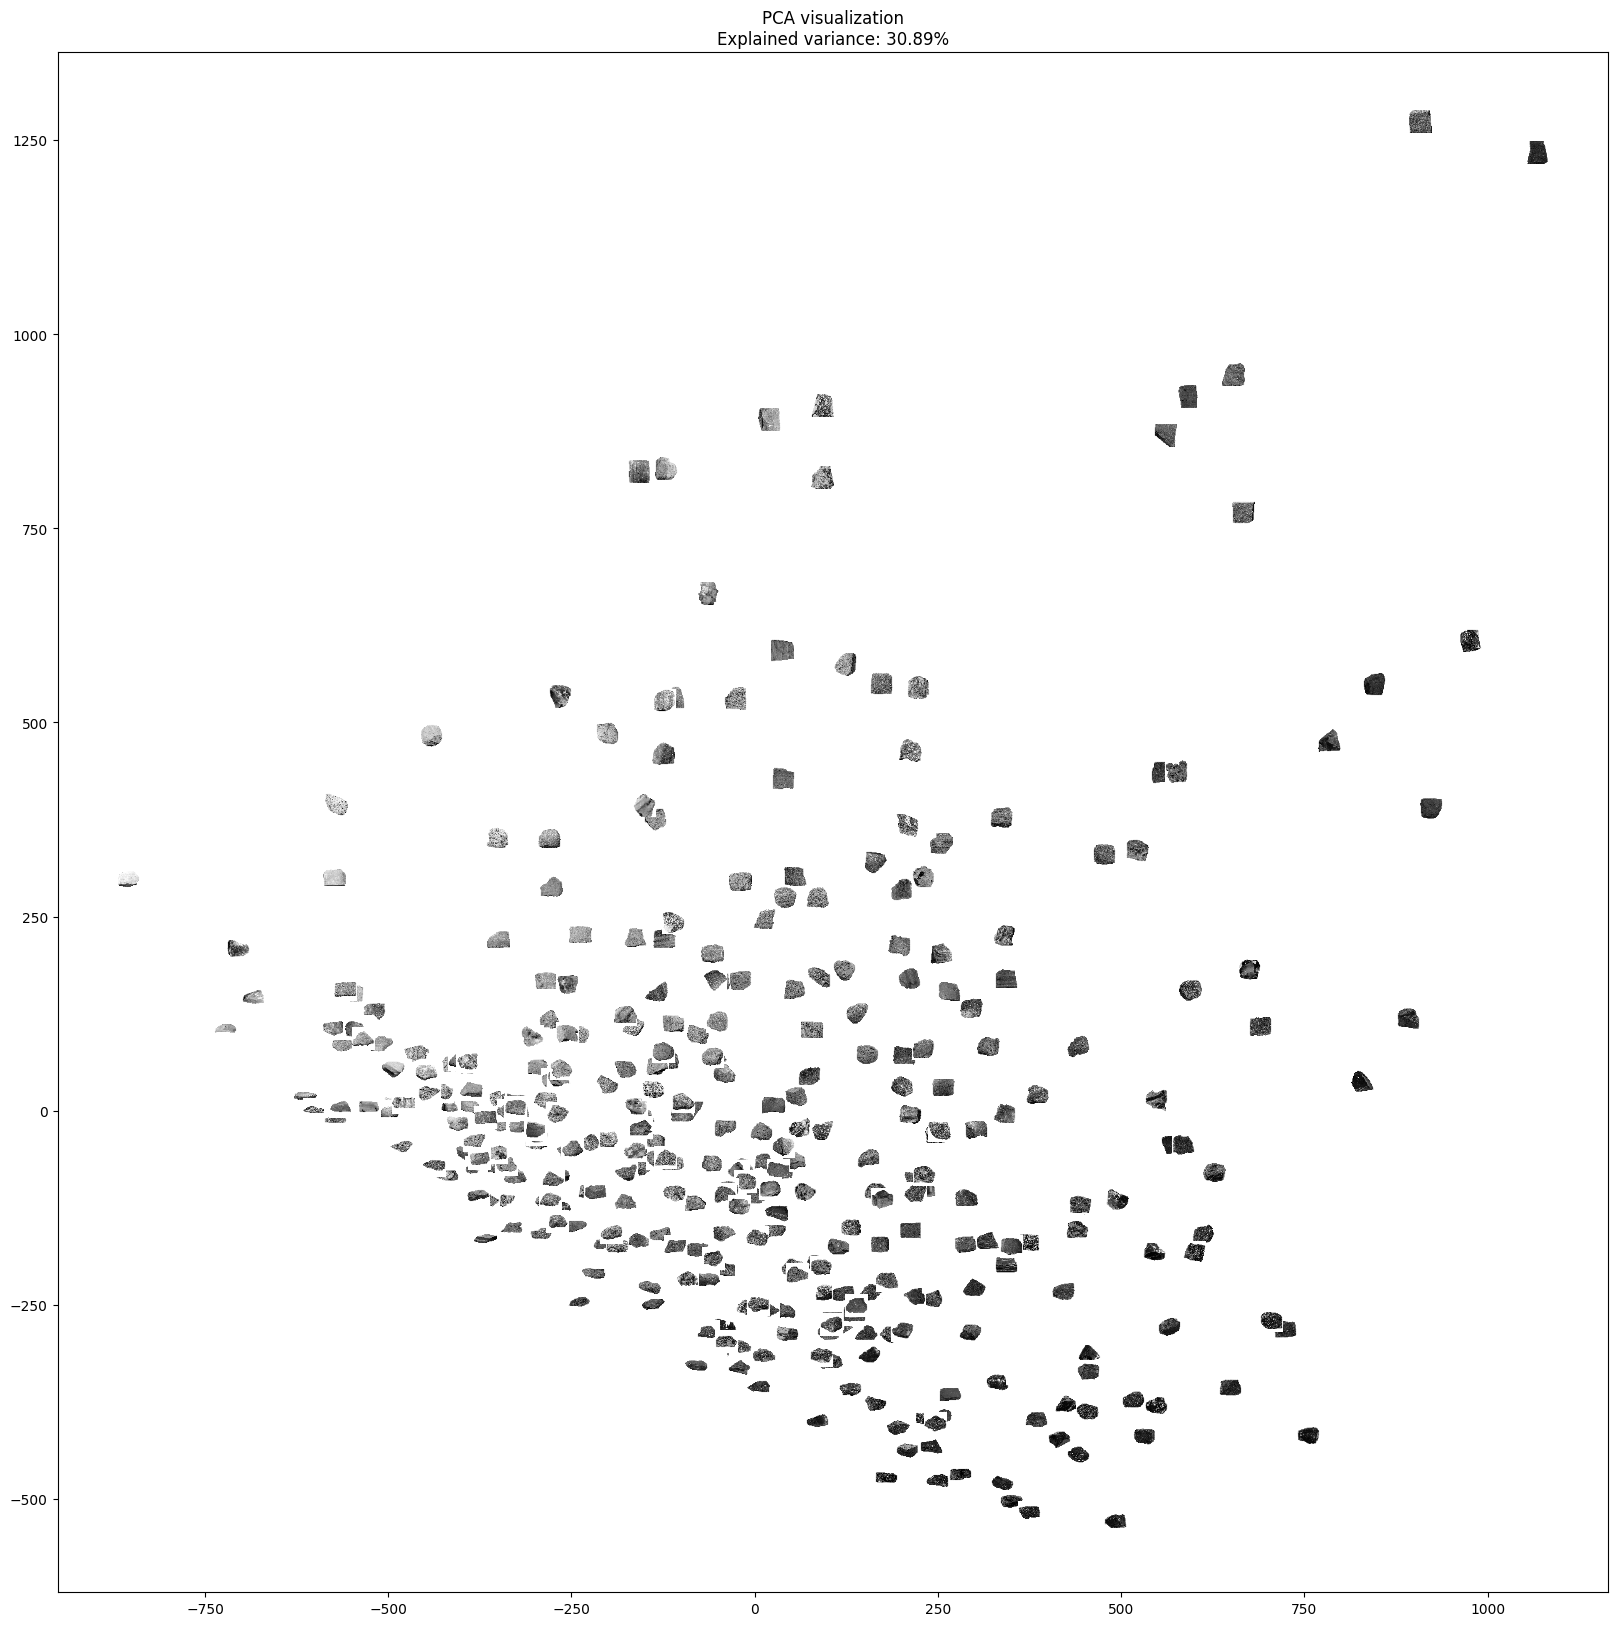

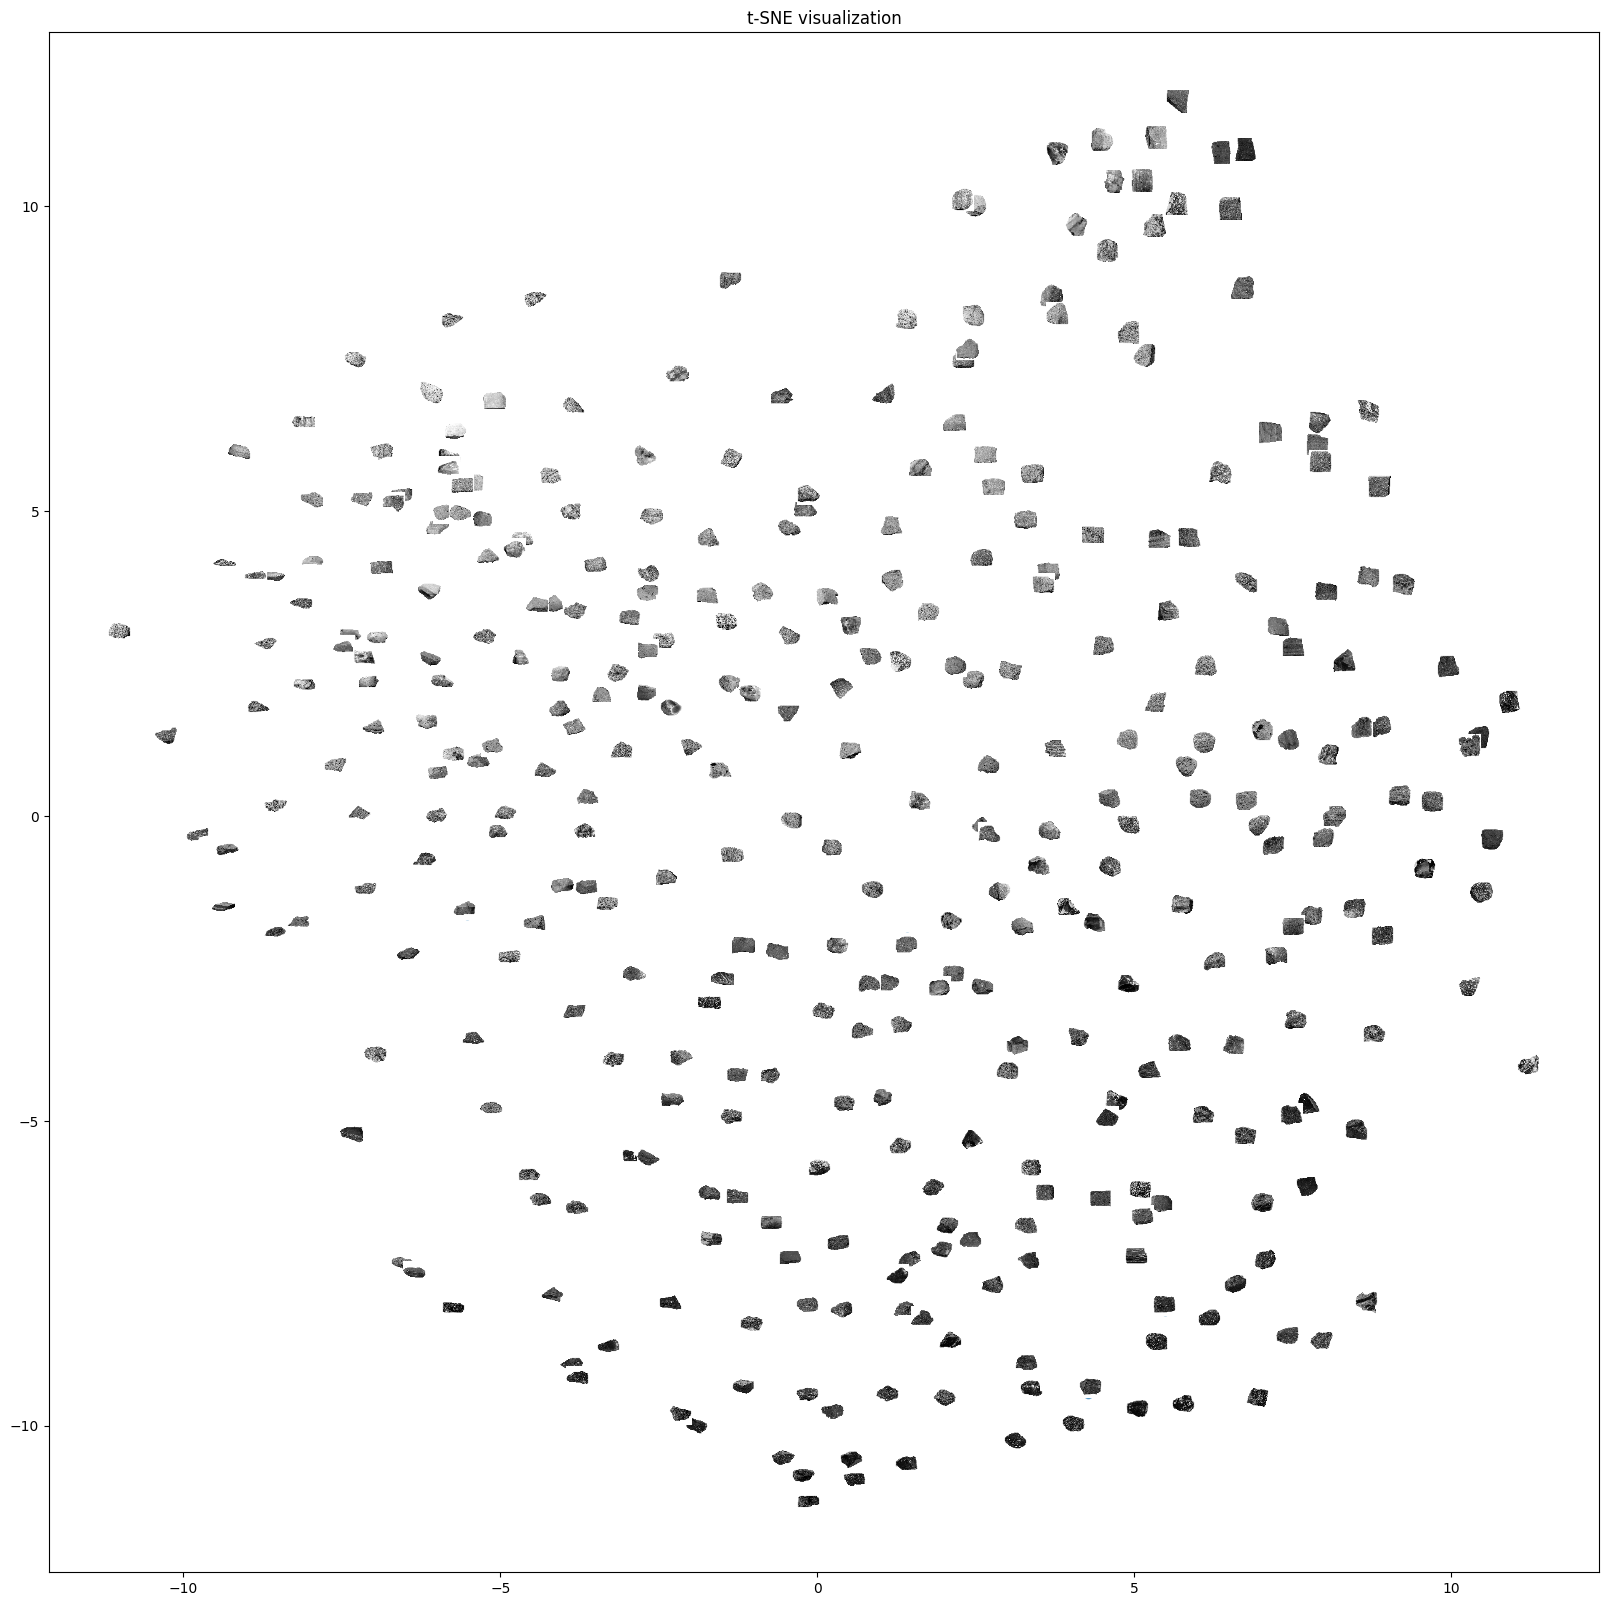

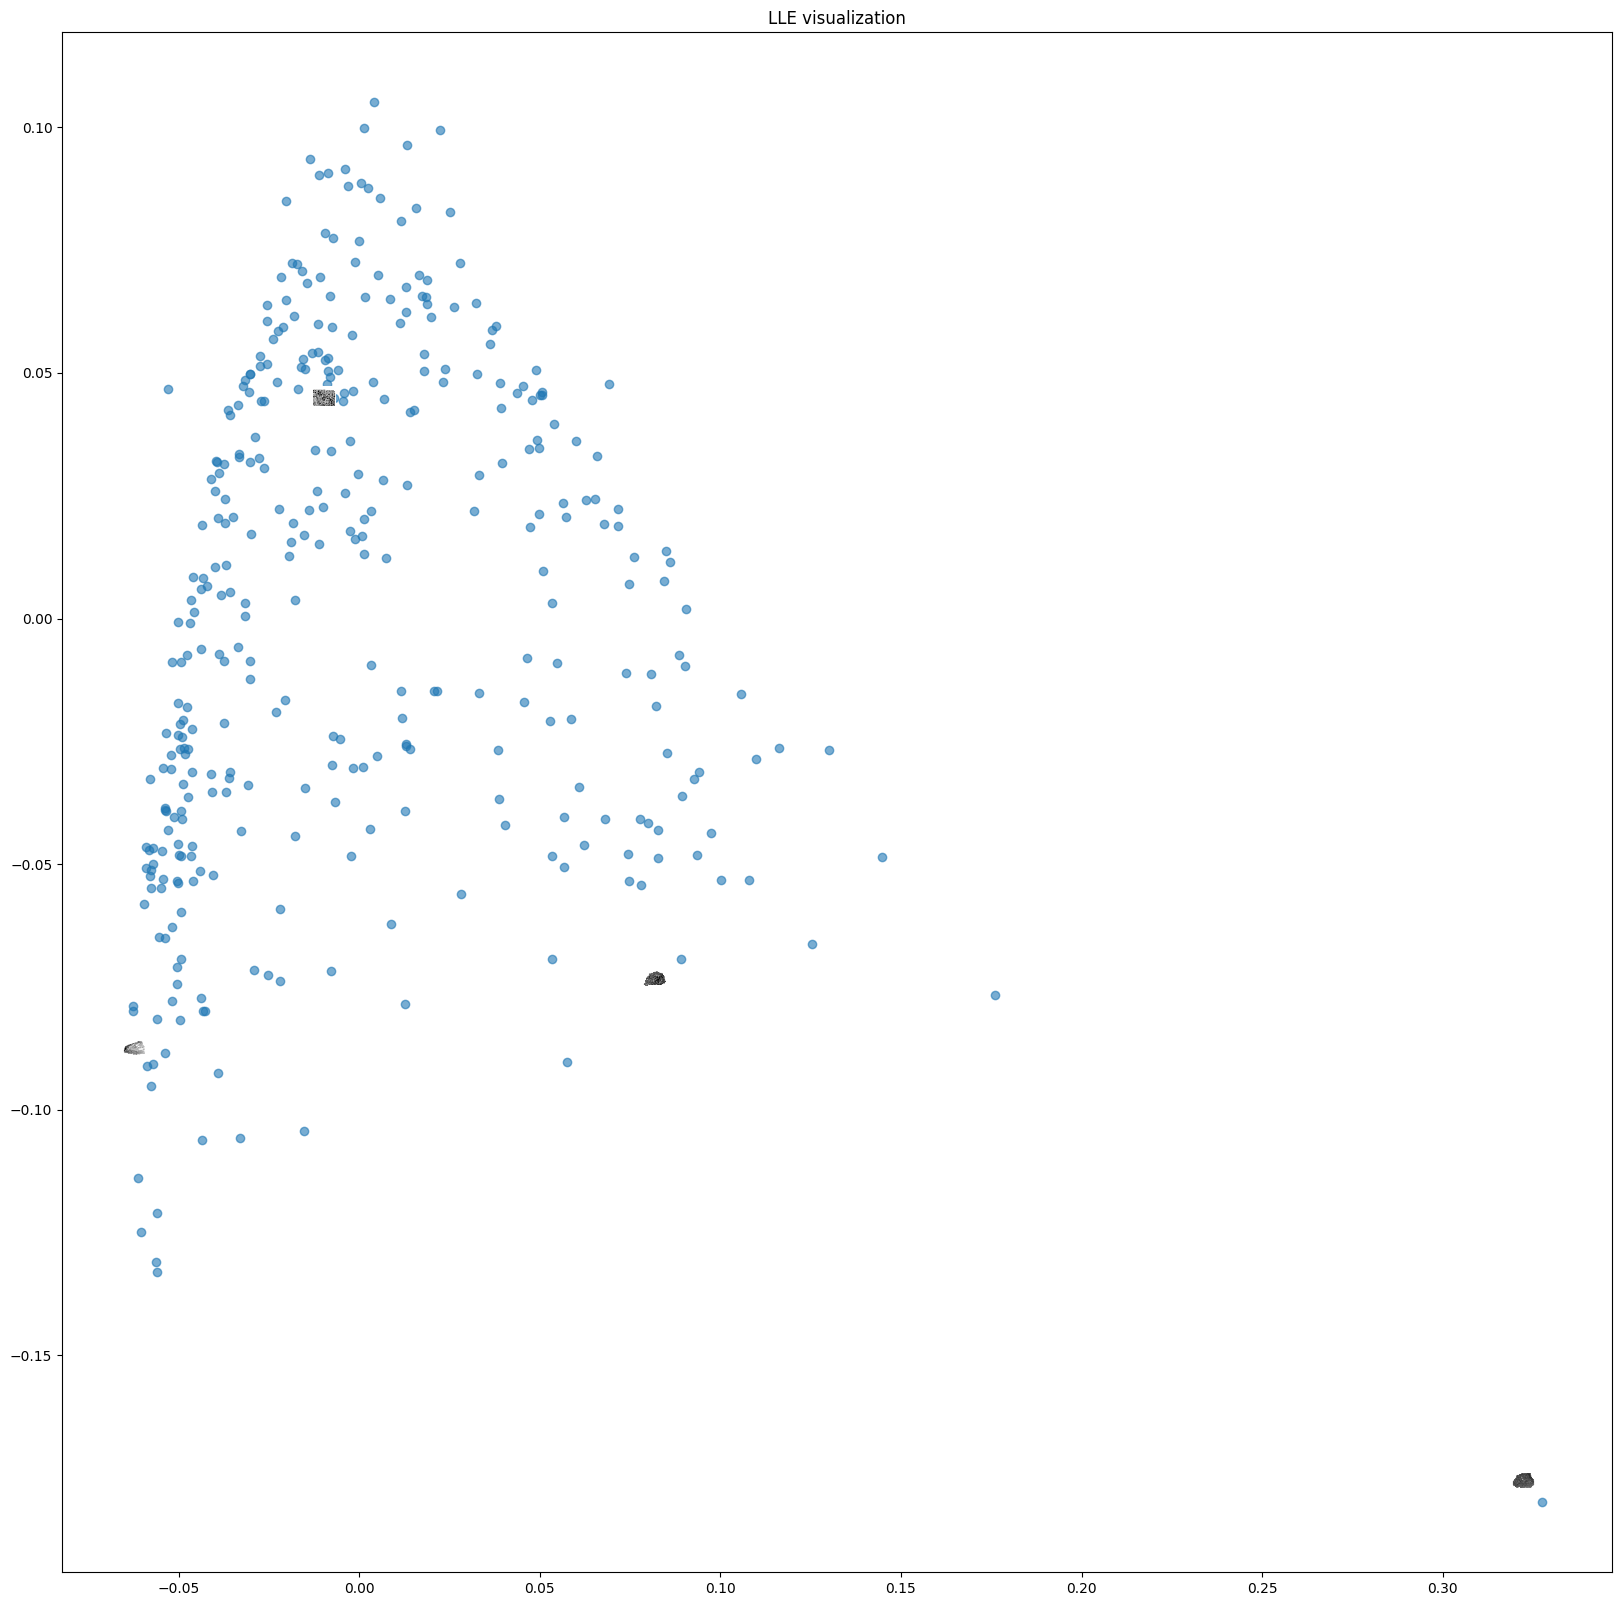

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


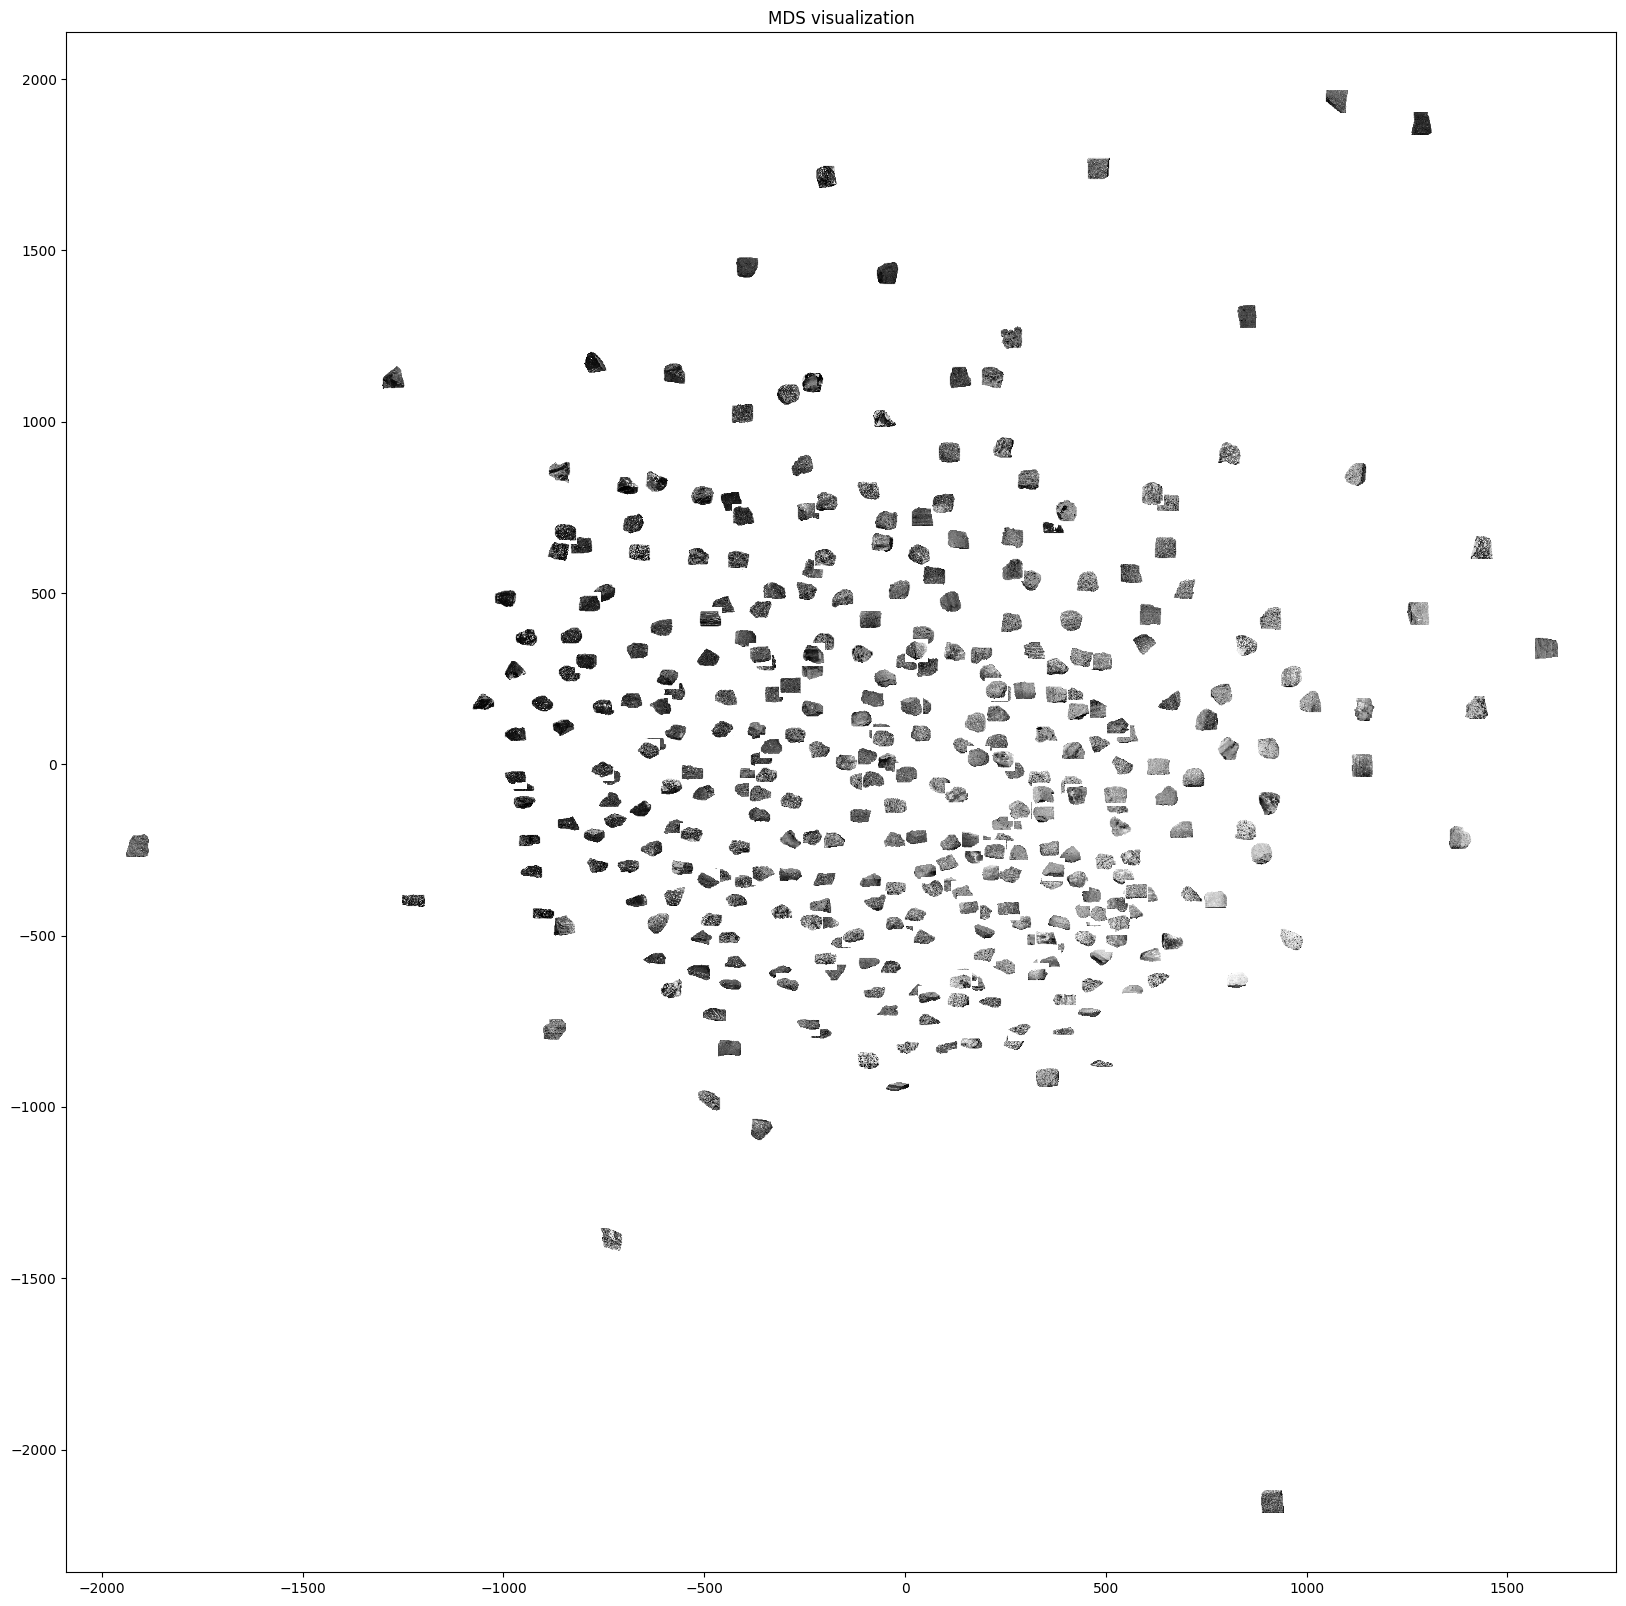

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import offsetbox
import cv2
import os

# Load and prepare the data
def load_rock_images(data_path):
    images = []
    original_images = []  # Store original images for visualization
    for file_name in os.listdir(data_path):
        img = cv2.imread(os.path.join(data_path, file_name))
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            original_images.append(gray_img)  # Store original size image
            images.append(gray_img.flatten())
    return np.array(images), np.array(original_images)

# Function to create scatter plot with sample images
def plot_with_images(X_embedded, images, title, figsize=(20, 20)):
    # Create figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    
    scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], alpha=0.6)
    
    # Show sample images
    shown_images = np.array([[1., 1.]])
    for i in range(X_embedded.shape[0]):
        dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
        if np.min(dist) < 0.02:  
            continue
        shown_images = np.r_[shown_images, [X_embedded[i]]]
        
        # Resize image for visualization
        resized_img = cv2.resize(images[i], (32, 32))
        
        # Add small image
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(resized_img, cmap='gray', zoom=0.5),
            X_embedded[i],
            frameon=False
        )
        ax.add_artist(imagebox)
    
    plt.title(title)
    plt.show()

# 4. Main processing function
def visualize_rock_dataset(data_path):
    # Load data
    X_flat, X_original = load_rock_images(data_path)
    print("Loaded images shape:", X_flat.shape)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_flat)
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    plot_with_images(X_pca, X_original, 
                    f'PCA visualization\nExplained variance: {sum(pca.explained_variance_ratio_):.2%}')
    
    # Apply t-SNE
    n_samples = min(5000, X_scaled.shape[0])
    if n_samples < X_scaled.shape[0]:
        indices = np.random.permutation(X_scaled.shape[0])[:n_samples]
        X_subset = X_scaled[indices]
        images_subset = X_original[indices]
    else:
        X_subset = X_scaled
        images_subset = X_original
    
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X_subset)
    plot_with_images(X_tsne, images_subset, 't-SNE visualization')
    
    # Apply LLE
    lle = LocallyLinearEmbedding(n_components=2, random_state=42, n_neighbors=10)
    X_lle = lle.fit_transform(X_subset)
    plot_with_images(X_lle, images_subset, 'LLE visualization')
    
    # Apply MDS
    mds = MDS(n_components=2, random_state=42)
    X_mds = mds.fit_transform(X_subset)
    plot_with_images(X_mds, images_subset, 'MDS visualization')

# 5. Run the visualization
data_path = '/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/360 Rocks'
visualize_rock_dataset(data_path)

In [4]:
categories = []

for file_name in os.listdir(data_path):
    category = file_name[0]  # Extract category ('I', 'M', 'S')
    categories.append(category)
    
categories = np.array(categories)

# Assign colors based on category
category_colors = {'I': 'red', 'M': 'blue', 'S': 'green'}
colors = [category_colors[cat] for cat in categories]

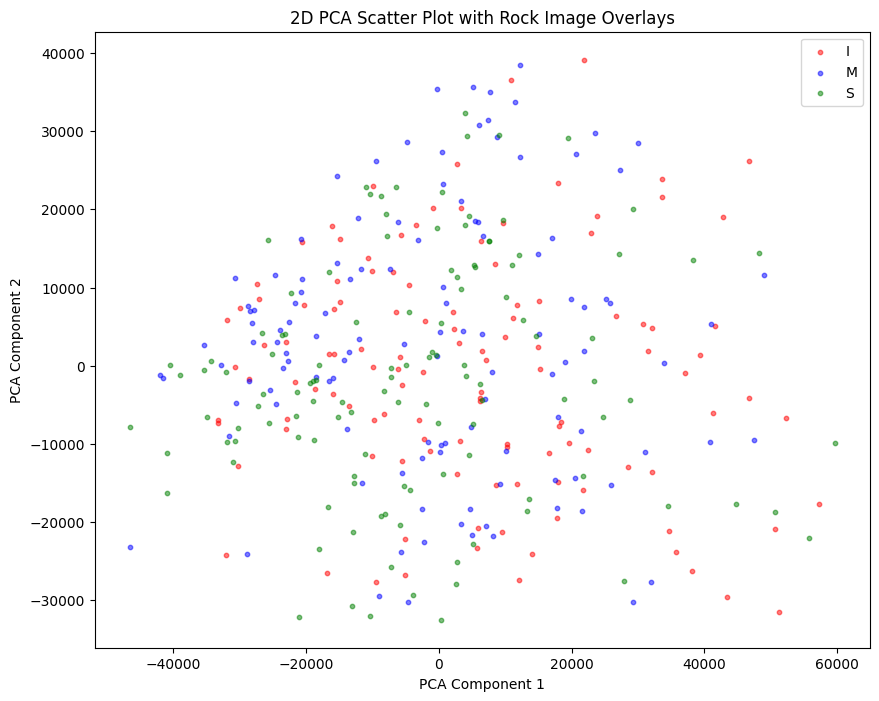

In [5]:
# Apply PCA
pca = PCA(n_components=2)
images_pca = pca.fit_transform(images)

# Plot PCA result as a scatter plot
plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    indices = np.where(categories == category)
    plt.scatter(images_pca[indices, 0], images_pca[indices, 1], c=color, label=category, alpha=0.5, s=10)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("2D PCA Scatter Plot with Rock Image Overlays")
plt.legend(["I", "M", "S"])
plt.show()


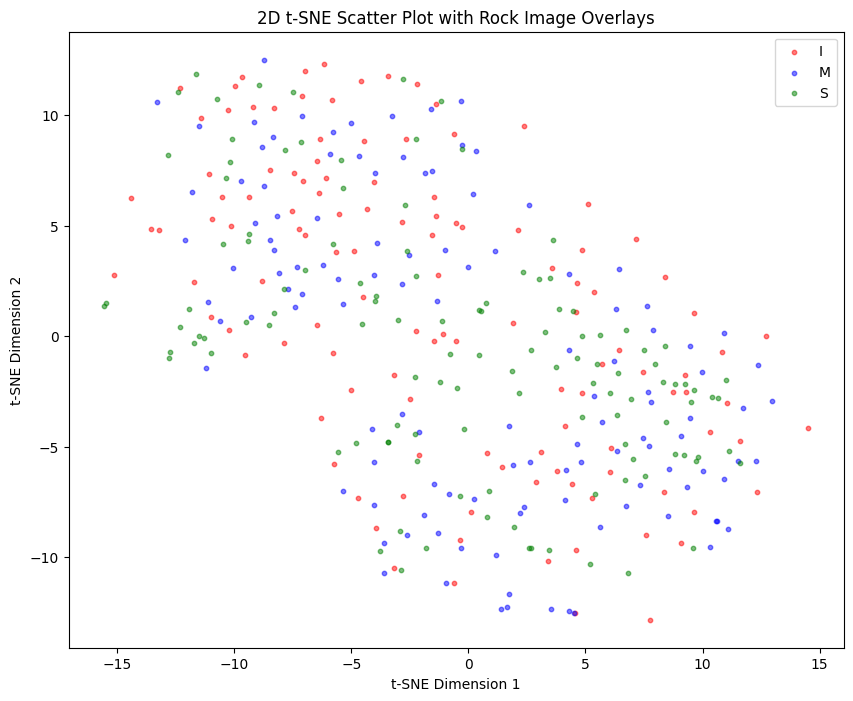

In [6]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
images_tsne = tsne.fit_transform(images)

# Plot t-SNE result as a scatter plot
plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    indices = np.where(categories == category)
    plt.scatter(images_tsne[indices, 0], images_tsne[indices, 1], c=color, label=category, alpha=0.5, s=10)

plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("2D t-SNE Scatter Plot with Rock Image Overlays")
plt.legend(["I", "M", "S"])
plt.show()

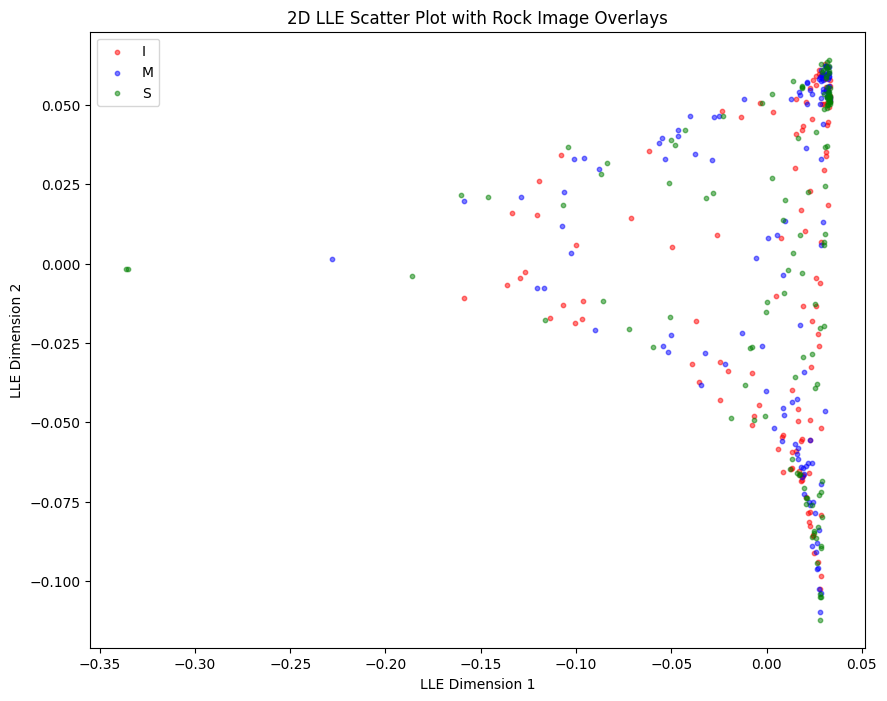

In [7]:
# Apply LLE
lle = LLE(n_components=2)
images_lle = lle.fit_transform(images)

# Plot LLE result as a scatter plot
plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    indices = np.where(categories == category)
    plt.scatter(images_lle[indices, 0], images_lle[indices, 1], c=color, label=category, alpha=0.5, s=10)

plt.xlabel("LLE Dimension 1")
plt.ylabel("LLE Dimension 2")
plt.title("2D LLE Scatter Plot with Rock Image Overlays")
plt.legend(["I", "M", "S"])
plt.show()


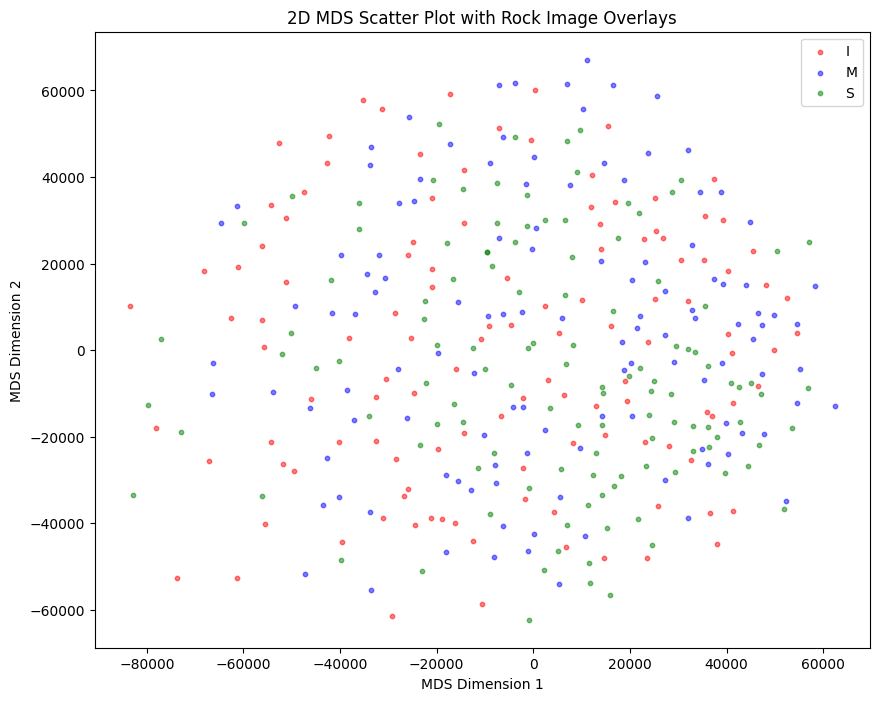

In [8]:
# Apply MDS
mds = MDS(n_components=2, random_state=42)
images_mds = mds.fit_transform(images)

# Plot MDS result as a scatter plot
plt.figure(figsize=(10, 8))
for category, color in category_colors.items():
    indices = np.where(categories == category)
    plt.scatter(images_mds[indices, 0], images_mds[indices, 1], c=color, label=category, alpha=0.5, s=10)

plt.xlabel("MDS Dimension 1")
plt.ylabel("MDS Dimension 2")
plt.title("2D MDS Scatter Plot with Rock Image Overlays")
plt.legend(["I", "M", "S"])
plt.show()

## C. Discuss your observations. [1 point]

Cluster Formation: The scatter plot indicates that rocks from the same category (I, M, or S) tend to cluster together. This suggests that each category has distinct visual features that are captured by the dimensionality reduction technique. For instance, rocks of the same type may share texture or color patterns that allow the PCA (or other methods) to group them closely in the 2D space.

Category Separation: There is noticeable separation between clusters representing different rock types. This indicates that the primary features contributing to the variance in the dataset can effectively differentiate the categories, as expected. The separation isn't perfect, meaning some overlap may exist, possibly due to visual similarities among some rocks of different types.

Effectiveness of Dimensionality Reduction: PCA (or the chosen method) has reduced the high-dimensional image data to two dimensions while preserving a significant portion of the variance, allowing for a clear visual representation. In the case of PCA, the explained variance by the first two components provides insight into how much of the original data's variability is captured in this 2D projection.

Overlayed Images for Feature Insight: The small rock images overlaid on specific points in the scatter plot provide a better understanding of the visual features that contribute to clustering. For example, rocks that cluster together might have similar textures or shades, which are likely captured by the principal components or other embedding methods used. These images help identify which features (e.g., roughness, smoothness, pattern) contribute the most to the distinctions between clusters.

Limitations: While PCA (or t-SNE, LLE, or MDS) shows good separation, there may still be overlapping clusters, suggesting that some visual distinctions between rock categories are subtle and may not be fully captured by just two dimensions. Higher-dimensional representations could potentially separate them further, though at the cost of visual simplicity.

# 4. Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, t-SNE, LLE and MDS to reduce the dimensionality of the images to 8. Then, compare those image embeddings with the ones from humans that are in the mds_360.txt file. Use Procrustes analysis to do the comparison (here is one example of how to do that mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data). Here matrix_with_human_data and matrix_with_pca_embeddings_data should be 360 by 8. disparity will tell you the difference in the data. Report disparity for each of the four dimensionality reduction methods. Compute the correlation coefficient between each dimension of mtx1 and mtx2 for each of the four methods - display results in a table. [7 points] 

In [42]:
print(human_data)

[[-3.743 -1.204  2.001]
 [ 2.332  1.625  0.985]
 [ 0.346  1.49  -3.795]
 ...
 [-3.475 -3.431 -2.184]
 [-0.051 -2.358  1.994]
 [ 1.134 -4.9    0.983]]


In [43]:
print("human_data shape:", human_data.shape)
print("lle_embeddings shape:", lle_embeddings.shape)

human_data shape: (360, 3)
lle_embeddings shape: (360, 8)


In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from scipy.spatial import procrustes
from scipy.stats import pearsonr
import pandas as pd

# Load the human-generated data
human_data = np.loadtxt('mds_360.txt')  # Load human data, assumed to be 360x8

images = np.random.rand(360, 1000)  # image data

# List to store results
disparities = {}
correlation_tables = {}

# Function to calculate correlation table
def calculate_correlation_table(mtx1, mtx2):
    correlation_data = []
    for i in range(mtx1.shape[1]):
        corr, _ = pearsonr(mtx1[:, i], mtx2[:, i])
        correlation_data.append(corr)
    return correlation_data

# PCA
pca = PCA(n_components=8)
pca_embeddings = pca.fit_transform(images)
mtx1, mtx2, disparity_pca = procrustes(human_data, pca_embeddings)
disparities['PCA'] = disparity_pca
correlation_tables['PCA'] = calculate_correlation_table(mtx1, mtx2)

# t-SNE
tsne = TSNE(n_components=8, method='exact', random_state=42)
tsne_embeddings = tsne.fit_transform(images)
mtx1, mtx2, disparity_tsne = procrustes(human_data, tsne_embeddings)
disparities['t-SNE'] = disparity_tsne
correlation_tables['t-SNE'] = calculate_correlation_table(mtx1, mtx2)

# LLE
lle = LocallyLinearEmbedding(n_components=8, random_state=42)
lle_embeddings = lle.fit_transform(images)
mtx1, mtx2, disparity_lle = procrustes(human_data, lle_embeddings)
disparities['LLE'] = disparity_lle
correlation_tables['LLE'] = calculate_correlation_table(mtx1, mtx2)

# MDS
mds = MDS(n_components=8, random_state=42)
mds_embeddings = mds.fit_transform(images)
mtx1, mtx2, disparity_mds = procrustes(human_data, mds_embeddings)
disparities['MDS'] = disparity_mds
correlation_tables['MDS'] = calculate_correlation_table(mtx1, mtx2)

# Print disparity results
print("Disparities for each method:")
for method, disparity in disparities.items():
    print(f"{method}: {disparity}")

# Create a table with correlation coefficients
correlation_df = pd.DataFrame(correlation_tables, index=[f'Dimension {i+1}' for i in range(8)])
print("\nCorrelation Coefficients between Aligned Dimensions for each Method:")
print(correlation_df)


Disparities for each method:
PCA: 0.9860982873128121
t-SNE: 0.9897544472305639
LLE: 0.9866347627292338
MDS: 0.9833786776241716

Correlation Coefficients between Aligned Dimensions for each Method:
                  PCA     t-SNE       LLE       MDS
Dimension 1  0.121176  0.110269  0.114162  0.115070
Dimension 2  0.088534  0.111280  0.115066  0.204312
Dimension 3  0.097472  0.144661  0.112456  0.070489
Dimension 4  0.149778  0.081991  0.121294  0.123304
Dimension 5  0.167542  0.127492  0.104816  0.101886
Dimension 6  0.116568  0.104462  0.151536  0.144202
Dimension 7  0.102500  0.102093  0.119234  0.125595
Dimension 8  0.107616  0.183497  0.077011  0.141212


# 5. Cluster the 360 images using K-Means.


## A. You can reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class. [4 points]

Number of components to retain 90% variance: 258


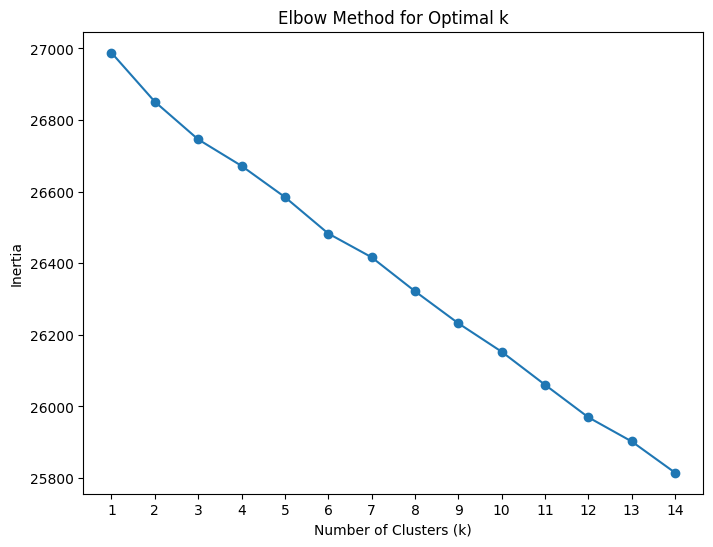

Cluster labels for each image: [3 4 4 2 2 3 2 3 2 1 2 2 3 2 2 0 3 2 3 3 3 3 3 3 1 3 2 2 3 3 4 4 3 3 3 3 2
 1 0 0 2 4 4 2 3 0 2 3 3 2 2 2 3 3 3 2 3 2 3 2 3 2 3 4 0 2 1 2 3 0 3 3 2 2
 1 3 0 0 0 4 1 3 2 3 2 2 3 3 3 2 2 2 4 1 4 3 3 3 3 2 3 3 3 0 3 2 3 0 3 1 3
 4 3 1 3 2 2 3 2 3 2 4 3 3 3 1 3 3 3 3 2 2 0 2 3 3 2 3 3 4 3 3 3 0 4 4 2 2
 0 1 3 2 1 2 2 2 2 4 2 3 3 2 1 2 3 0 0 2 1 4 4 3 3 2 2 3 2 3 2 1 1 1 3 2 0
 1 3 2 1 2 1 1 3 3 2 3 3 3 3 2 3 3 1 3 2 1 3 0 3 0 4 3 4 0 2 3 0 4 3 1 2 3
 1 4 3 2 2 3 2 1 4 2 2 2 0 3 3 1 2 1 3 1 1 3 4 3 2 1 2 3 3 3 3 2 2 2 3 3 0
 4 0 3 4 3 2 3 2 1 4 2 3 2 3 2 0 4 3 3 2 1 2 1 3 4 4 2 3 2 2 1 2 3 4 3 4 0
 4 2 3 1 3 3 4 3 3 3 3 0 1 2 3 0 3 2 0 3 3 3 3 4 3 2 4 2 3 4 3 3 2 2 3 2 2
 2 2 4 3 1 3 3 3 2 3 3 4 2 2 3 2 2 3 2 3 3 4 3 3 2 4 2]


In [17]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

images = np.random.rand(360, 1000)  # image data

# Apply PCA to retain at least 90% of the variance
pca = PCA(0.90)  # Retain 90% of the variance
pca_images = pca.fit_transform(images)

# Print the number of components chosen to retain 90% of variance
print(f"Number of components to retain 90% variance: {pca.n_components_}")

# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 15)  # Choose a reasonable range to observe the "elbow" point

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_images)
    inertia.append(kmeans.inertia_)

# Step 3: Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.xticks(cluster_range)
plt.show()

# Step 4: Fit K-Means with the optimal number of clusters (based on elbow plot)
k_optimal = 5 
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(pca_images)

# Assign labels to the images
labels = kmeans.labels_
print("Cluster labels for each image:", labels)


## B. Set the number of clusters to 3 and report clustering accuracy. [4 points]

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

# Assuming `images` is the data matrix and `true_labels` contains the ground-truth labels
# Replace with actual ground-truth labels if available
true_labels = np.random.randint(0, 3, 360)  # Placeholder for ground-truth labels

# Step 1: Apply PCA to reduce dimensionality while retaining 90% of variance
pca = PCA(0.90)
pca_images = pca.fit_transform(images)

# Step 2: Fit K-Means with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_images)

# Step 3: Get cluster labels
predicted_labels = kmeans.labels_

# Step 4: Calculate clustering accuracy using Adjusted Rand Index
# ARI measures the similarity between the true labels and the predicted cluster labels
clustering_accuracy = adjusted_rand_score(true_labels, predicted_labels)
print(f"Clustering Accuracy (Adjusted Rand Index): {clustering_accuracy:.4f}")

Clustering Accuracy (Adjusted Rand Index): -0.0040


# 6. Cluster the 360 images using EM.

## A. You can again reduce the dimensionality using PCA if you wish, but keep at least 90% of the variance. Determine the number of clusters using one of the techniques we discussed in class. [4 points]

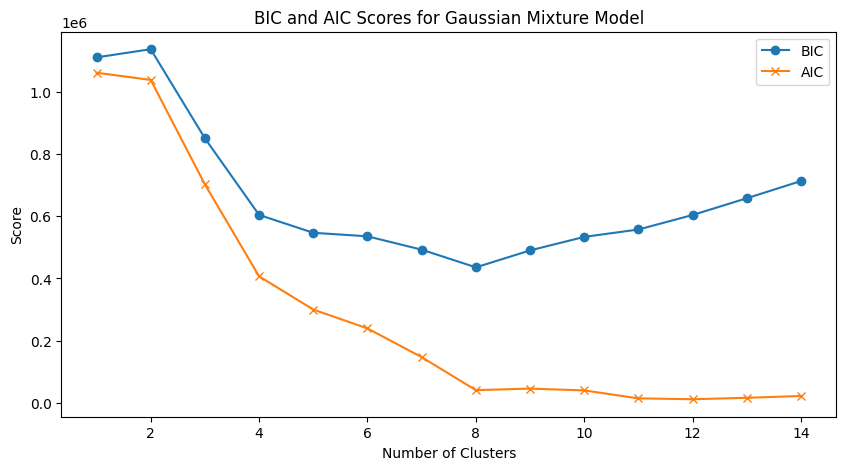

Optimal number of clusters based on BIC: 8
Cluster labels: [4 1 5 7 0 3 3 6 6 7 1 5 5 0 6 7 3 2 2 3 3 4 0 6 6 4 6 6 4 2 3 2 4 7 3 4 5
 6 5 0 4 4 3 2 4 4 7 6 6 0 1 4 7 7 3 4 4 4 3 6 3 0 0 5 4 4 0 5 0 3 1 7 0 4
 0 0 3 4 5 6 3 4 0 5 7 5 3 3 0 6 4 6 5 5 0 1 7 7 5 5 2 6 4 6 3 6 3 2 4 2 3
 5 2 6 6 6 5 0 2 0 2 5 2 0 4 6 1 6 2 0 6 6 2 4 0 1 2 4 1 3 1 4 4 6 1 2 3 6
 2 3 2 7 0 3 2 2 6 3 5 5 2 3 1 6 6 3 3 6 1 3 6 5 7 0 2 0 6 0 6 4 6 1 4 3 1
 6 4 7 1 5 2 3 2 4 6 2 6 5 2 3 6 4 5 2 3 1 5 7 6 4 4 5 5 5 6 5 2 3 3 6 1 4
 2 2 6 5 4 5 7 4 4 7 7 2 2 0 5 1 1 6 3 6 1 3 3 1 5 1 2 1 1 0 4 1 5 5 3 4 3
 0 4 7 6 6 7 7 6 2 3 4 5 5 7 4 0 5 1 7 0 2 3 1 5 7 5 6 7 2 3 7 4 6 3 4 0 0
 0 3 3 1 7 7 2 6 4 0 5 6 4 7 5 3 5 7 1 3 4 6 4 2 7 2 0 4 4 6 3 5 7 3 5 1 6
 5 3 4 5 0 5 4 5 4 6 3 7 2 4 7 4 1 7 1 6 6 5 6 5 4 7 5]


In [6]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Apply PCA to retain 90% of the variance
pca = PCA(0.90)
pca_images = pca.fit_transform(images) 

# Step 2: Determine the optimal number of clusters using BIC
bic_scores = []
aic_scores = []
n_clusters_range = range(1, 15)  

for n_clusters in n_clusters_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(pca_images)
    bic_scores.append(gmm.bic(pca_images))
    aic_scores.append(gmm.aic(pca_images))

# Plot BIC and AIC scores to visualize the optimal number of clusters
plt.figure(figsize=(10, 5))
plt.plot(n_clusters_range, bic_scores, label='BIC', marker='o')
plt.plot(n_clusters_range, aic_scores, label='AIC', marker='x')
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.title("BIC and AIC Scores for Gaussian Mixture Model")
plt.show()

# Step 3: Choose the number of clusters based on the lowest BIC score
optimal_n_clusters = n_clusters_range[np.argmin(bic_scores)]
print(f"Optimal number of clusters based on BIC: {optimal_n_clusters}")

# Step 4: Fit GMM with the optimal number of clusters
gmm = GaussianMixture(n_components=optimal_n_clusters, random_state=42)
gmm.fit(pca_images)
cluster_labels = gmm.predict(pca_images)

# Output the cluster labels
print("Cluster labels:", cluster_labels)

## B. Set the number of clusters to 3 and report clustering accuracy. [4 points]

In [8]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Assuming `images` is the matrix of 360 images.

# Step 1: Apply PCA to retain 90% of the variance
pca = PCA(0.90)
pca_images = pca.fit_transform(images)

# Step 2: Set the number of clusters to 3 and fit the GMM model
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(pca_images)
predicted_labels = gmm.predict(pca_images)

# Step 3: Evaluate clustering using Silhouette Score and Davies-Bouldin Index
silhouette_avg = silhouette_score(pca_images, predicted_labels)
davies_bouldin = davies_bouldin_score(pca_images, predicted_labels)

print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")

Silhouette Score: 0.0801
Davies-Bouldin Index: 2.5901


## C. Use the model to generate 20 new rocks (using the sample() method), and visualize them in the original image space (since you used PCA, you will need to use its inverse_transform() method).  [4 points]

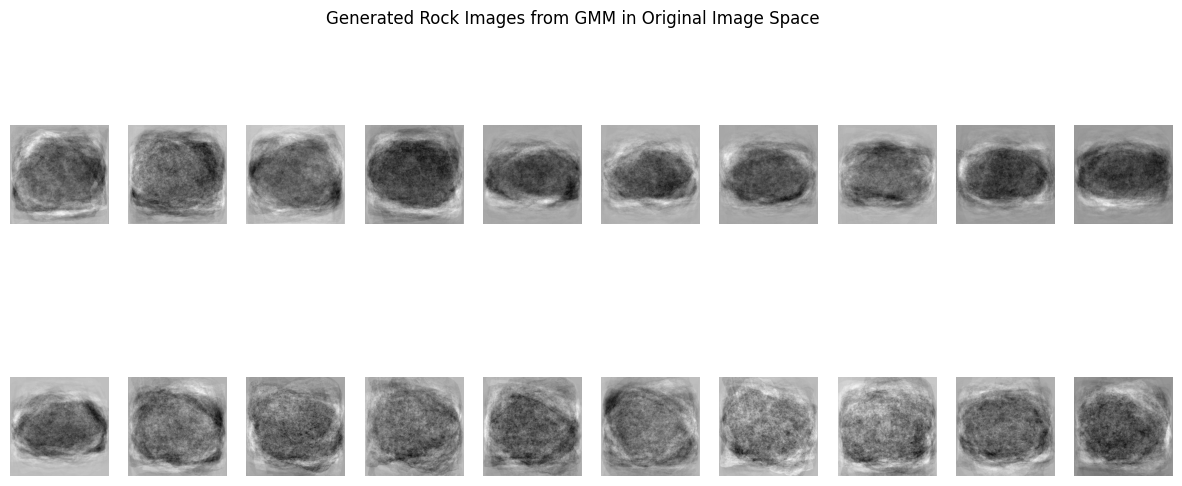

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Step 1: Apply PCA to retain 90% of the variance (assuming images is the data matrix)
pca = PCA(0.90)
pca_images = pca.fit_transform(images) 

# Step 2: Train Gaussian Mixture Model (GMM) on the reduced data
n_clusters = 3  # Number of clusters used in the previous part
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm.fit(pca_images)

# Step 3: Generate 20 new samples in the PCA-reduced space
generated_samples, _ = gmm.sample(20)  # 20 samples in reduced dimensionality

# Step 4: Project generated samples back to the original space using PCA's inverse transform
generated_images = pca.inverse_transform(generated_samples)

# Step 5: Visualize the generated images
plt.figure(figsize=(15, 6))
for i in range(20):
    plt.subplot(2, 10, i + 1) 
    plt.imshow(generated_images[i].reshape(800, 800), cmap='gray') 
    plt.axis('off')
plt.suptitle("Generated Rock Images from GMM in Original Image Space")
plt.show()


# 7. Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training. We recommend using Colab (the free version should be totally fine), but make sure to run it with a GPU to speed up the training - to add a GPU on Colab go to Edit->Notebook settings). 

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import os
import time

# Define paths
rocks360_data_path = '/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/360 Rocks'
rocks120_data_path = '/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/120 Rocks'

# Set target image size
target_size = (128, 128)  # Reducing size for faster training

# Helper function to load and preprocess images
def load_images(data_path, target_size):
    images = []
    labels = []
    for file_name in os.listdir(data_path):
        label = file_name[0]  # Extract category from the first letter (I, M, S)
        img = cv2.imread(os.path.join(data_path, file_name))
        if img is not None:
            resized_img = cv2.resize(img, target_size)
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
            images.append(gray_img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load and preprocess data
train_images, train_labels = load_images(rocks360_data_path, target_size)
val_images, val_labels = load_images(rocks120_data_path, target_size)

# Reshape images for CNN
train_images = train_images.reshape(-1, target_size[0], target_size[1], 1)
val_images = val_images.reshape(-1, target_size[0], target_size[1], 1)

# Encode labels as integers
label_mapping = {'I': 0, 'M': 1, 'S': 2}
train_labels = np.array([label_mapping[label] for label in train_labels])
val_labels = np.array([label_mapping[label] for label in val_labels])

# Convert labels to categorical (one-hot encoding)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=3)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=3)

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='relu'),  # Last layer before softmax with 8 neurons
    Dense(3, activation='softmax')  # Output layer with 3 neurons (one for each category)
])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

# Define the model architecture using the Functional API
input_tensor = Input(shape=(128, 128, 1))  # Define input shape explicitly
x = Conv2D(32, (3, 3), activation='relu')(input_tensor)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
penultimate_output = Dense(8, activation='relu', name="penultimate_layer")(x)  # Penultimate layer
output_tensor = Dense(3, activation='softmax')(penultimate_output)  # Final output layer

# Create the Functional API model
model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Extract activations for the penultimate layer
penultimate_layer_model = Model(inputs=model.input, outputs=model.get_layer("penultimate_layer").output)

# Dummy initialization
dummy_input = np.zeros((1, 128, 128, 1))  # Use a dummy batch to initialize the model
_ = model.predict(dummy_input)

# Extract activations for training and validation datasets
train_activations = penultimate_layer_model.predict(train_images, verbose=1)
val_activations = penultimate_layer_model.predict(val_images, verbose=1)

# Print activations
print("Train activations shape:", train_activations.shape)
print("Validation activations shape:", val_activations.shape)

# Normalize if necessary
train_activations_normalized = train_activations - train_activations.mean(axis=0)
val_activations_normalized = val_activations - val_activations.mean(axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Train activations shape: (360, 8)
Validation activations shape: (120, 8)


In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import cv2
import os
import time
import matplotlib.pyplot as plt

# Define paths
rocks360_data_path = '/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/360 Rocks'
rocks120_data_path = '/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/120 Rocks'

# Set target image size
target_size = (128, 128)  # Reducing size for faster training

# Check if paths exist
if not os.path.isdir(rocks360_data_path) or not os.path.isdir(rocks120_data_path):
    raise FileNotFoundError("One or both of the specified data paths do not exist.")

# Label mapping
label_mapping = {'I': 0, 'M': 1, 'S': 2}

# Helper function to load and preprocess images
def load_images(data_path, target_size):
    images = []
    labels = []
    for file_name in os.listdir(data_path):
        if file_name[0] not in label_mapping:
            print(f"Skipping file {file_name} as it does not have a valid label.")
            continue
        label = file_name[0]  # Extract category from the first letter (I, M, S)
        img_path = os.path.join(data_path, file_name)
        img = cv2.imread(img_path)
        
        if img is not None:
            # Resize and convert to grayscale
            resized_img = cv2.resize(img, target_size)
            gray_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)
            # Normalize image to [0, 1] range
            gray_img = gray_img / 255.0
            images.append(gray_img)
            labels.append(label_mapping[label])
        else:
            print(f"Warning: Could not load image {img_path}")

    return np.array(images), np.array(labels)

# Load and preprocess data
train_images, train_labels = load_images(rocks360_data_path, target_size)
val_images, val_labels = load_images(rocks120_data_path, target_size)

# Reshape images for CNN
train_images = train_images.reshape(-1, target_size[0], target_size[1], 1)
val_images = val_images.reshape(-1, target_size[0], target_size[1], 1)

# Convert labels to categorical (one-hot encoding)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=3)
val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=3)

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(target_size[0], target_size[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(8, activation='relu'),  # Last layer before softmax with 8 neurons
    Dense(3, activation='softmax')  # Output layer with 3 neurons (one for each category)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## A. Report the training time (use code to do this). [1 point]

In [4]:
# Train the model and measure the time taken
start_time = time.time()
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels), batch_size=32)
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.3204 - loss: 303.3145 - val_accuracy: 0.3417 - val_loss: 1.4739
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3296 - loss: 1.1775 - val_accuracy: 0.3333 - val_loss: 1.1446
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.3841 - loss: 1.0234 - val_accuracy: 0.3583 - val_loss: 1.1975
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5195 - loss: 0.9197 - val_accuracy: 0.4417 - val_loss: 1.3647
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.6889 - loss: 0.7188 - val_accuracy: 0.3667 - val_loss: 1.5099
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7728 - loss: 0.5944 - val_accuracy: 0.4417 - val_loss: 2.1843
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8341 - loss: 0.4649 - val_accuracy: 0.4167 - val_loss: 3.0176
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.8749 - loss: 0.3423 - val_accuracy: 

## B. Plot training and validation loss and accuracy as a function of training epochs. [13 points]

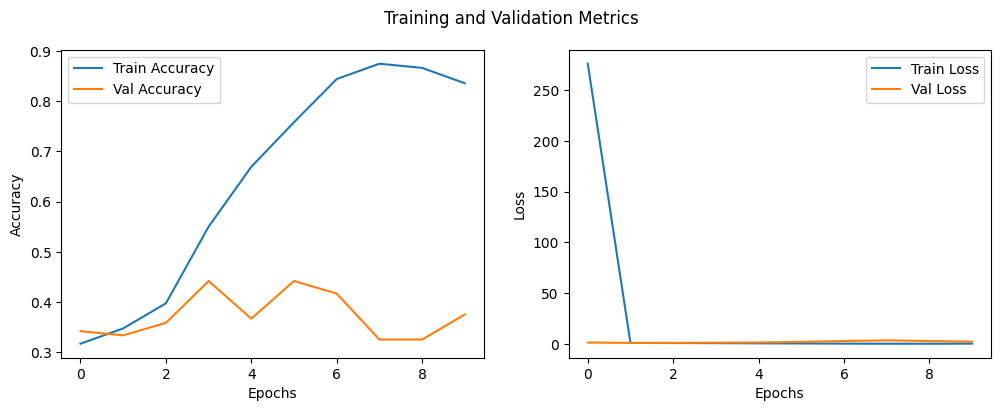

In [5]:
# Display training and validation accuracy and loss over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.suptitle("Training and Validation Metrics")
plt.show()


## C. How many parameters does the network have? How many of those parameters are bias parameters? [1 points]

In [35]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ penultimate_layer (Dense)       │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,803 (28.20 MB)

 Trainable params: 7,392,803 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

### First Conv2D Layer (Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1))):
Filters: 32

Kernel size: 

3×3

Input channels: 1 (grayscale)

Parameters per filter: 

3×3×1=9

Total parameters (weights): 

32×9=288

Biases: 32 (one per filter)

Total parameters for this layer: 

288+32=320

### MaxPooling2D Layer (MaxPooling2D((2, 2))):
No parameters are learned in pooling layers.

Total parameters: 0

### Second Conv2D Layer (Conv2D(64, (3, 3), activation='relu')):

Filters: 64

Kernel size: 

3×3

Input channels from the previous layer: 32

Parameters per filter: 

3×3×32=288

Total parameters (weights): 
64×288=18,432
Biases: 64

Total parameters for this layer: 
18,432+64=18,496

### Second MaxPooling2D Layer (MaxPooling2D((2, 2))):
No parameters are learned in pooling layers.

Total parameters: 0

### Flatten Layer:
Converts the output of the previous layer into a 1D vector for the dense layers.

No parameters are learned in the flatten layer.

Total parameters: 0

### First Dense Layer (Dense(128, activation='relu')):
Total parameters for this layer: 7,372,928 

### Second Dense Layer (Dense(8, activation='relu')):
Input size: 128

Parameters (weights): 

128×8=1,024

Biases: 8

Total parameters for this layer: 

1,024+8=1,032

### Output Dense Layer (Dense(3, activation='softmax')):
Input size: 8

Parameters (weights): 

8×3=24

Biases: 3

Total parameters for this layer: 

24+3=27

### Total Parameters and Bias Parameters:
Summing up all layers:

Total parameters: 

320 + 18,496 + 7,372,928 + 1,032 + 27 = 7,392,803

Bias parameters: 

32 + 64 + 128 + 8 + 3 = 235

## D. Compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table. [3 points]

In [34]:
import numpy as np
import pandas as pd
from scipy.spatial import procrustes
from scipy.stats import pearsonr

# Load human data
mds_360 = np.loadtxt('/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/mds_360.txt')
mds_120 = np.loadtxt('/Users/harshit/Documents/Semester 1/Applied ML/Homework 3/mds_120.txt')

training_data_8_neurons = train_activations_normalized
validation_data_8_neurons = val_activations_normalized

# Function for Procrustes analysis and correlation computation
def analyze_procrustes(neural_data, human_data):
    mtx1, mtx2, disparity = procrustes(human_data, neural_data)

    # Compute correlation coefficients for each dimension
    correlations = [pearsonr(mtx1[:, i], mtx2[:, i])[0] for i in range(mtx1.shape[1])]
    
    # Create result table
    result_table = pd.DataFrame({
        "Dimension": range(1, mtx1.shape[1] + 1),
        "Correlation Coefficient": correlations
    })
    return disparity, result_table

# Perform analysis for training and validation data
disparity_train, results_train = analyze_procrustes(training_data_8_neurons, mds_360)
disparity_val, results_val = analyze_procrustes(validation_data_8_neurons, mds_120)

# Display results
print("Training Data Results")
print("Disparity:", disparity_train)
print(results_train)

print("\nValidation Data Results")
print("Disparity:", disparity_val)
print(results_val)


Training Data Results
Disparity: 0.9818106423357489
   Dimension  Correlation Coefficient
0          1                 0.072756
1          2                 0.096994
2          3                 0.125516
3          4                 0.167195
4          5                 0.167139
5          6                 0.198667
6          7                 0.099305
7          8                 0.095576

Validation Data Results
Disparity: 0.9685116545762414
   Dimension  Correlation Coefficient
0          1                 0.102166
1          2                 0.129214
2          3                 0.179960
3          4                 0.267288
4          5                 0.184674
5          6                 0.263535
6          7                 0.163415
7          8                 0.143262
